In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
from joblib import Parallel, delayed
import multiprocessing

In [4]:
def estimate(y, X):
    model = OLS(y, X).fit()
    return model.params, model.resid, model.mse_resid, model.bse

In [5]:
def adf_hatemi_j(e, max_lag=12, criterion='bic'):
    n = len(e)
    de = np.diff(e)
    ic_vals, t_stats = [], []

    for k in range(max_lag + 1):
        y = de[k:]
        X = e[k:n-1].reshape(-1, 1)
        for j in range(1, k+1):
            X = np.hstack([X, de[k-j:n-1-j].reshape(-1, 1)])
        X = add_constant(X)
        model = OLS(y, X).fit()
        ic = model.bic if criterion == 'bic' else model.aic
        ic_vals.append(ic)
        t_stats.append(model.tvalues[1])

    best_idx = np.argmin(ic_vals) if criterion in ['aic', 'bic'] else max_lag
    return t_stats[best_idx], best_idx

In [6]:
def phillips_test(y, X):
    model = OLS(y, X).fit()
    e = model.resid
    n = len(e)

    be = np.dot(e[1:], e[:-1]) / np.dot(e[:-1], e[:-1])
    ue = e[1:] - be * e[:-1]
    nu = len(ue)
    bu = np.dot(ue[1:], ue[:-1]) / np.dot(ue[:-1], ue[:-1])
    uu = ue[1:] - bu * ue[:-1]
    su = np.mean(uu**2)

    a2 = (4 * bu**2 * su / (1 - bu)**8) / (su / (1 - bu)**4)
    bandwidth = int(1.3221 * (a2 * nu)**0.2)

    lemda = 0
    for j in range(1, bandwidth + 1):
        gamma = np.dot(ue[:-j], ue[j:]) / nu
        c = j / bandwidth
        w = (75 / (6 * np.pi * c)**2) * (np.sin(1.2 * np.pi * c)/(1.2 * np.pi * c) - np.cos(1.2 * np.pi * c))
        lemda += w * gamma

    p = (np.sum(e[1:] * e[:-1]) - lemda) / np.sum(e[:-1] ** 2)
    za = n * (p - 1)
    sigma2 = 2 * lemda + np.sum(ue**2) / nu
    s = sigma2 / np.sum(e[:-1] ** 2)
    zt = (p - 1) / np.sqrt(s)

    return za, zt

In [7]:
def hatemi_j_test(y, X, model_type=4, max_lag=12, criterion='bic', step=10):
    n = len(y)
    begin = int(0.15 * n)
    final1 = int(0.70 * n)
    final2 = int(0.85 * n)

    t1_range = range(begin, final1 + 1, step)
    surface_adf, surface_za, surface_zt = [], [], []

    total = sum(len(range(t1 + begin, final2 + 1, step)) for t1 in t1_range)
    pbar = tqdm(total=total, desc="Hatemi-J test 진행 중")

    for t1 in t1_range:
        row_adf, row_za, row_zt = [], [], []
        for t2 in range(t1 + begin, final2 + 1, step):
            try:
                D1 = np.concatenate([np.zeros(t1), np.ones(n - t1)])
                D2 = np.concatenate([np.zeros(t2), np.ones(n - t2)])
                if model_type == 2:
                    X1 = np.column_stack([np.ones(n), D1, D2, X])
                elif model_type == 3:
                    trend = np.arange(1, n + 1)
                    X1 = np.column_stack([np.ones(n), D1, D2, trend, X])
                elif model_type == 4:
                    X1 = np.column_stack([np.ones(n), D1, D2, X, D1[:, None]*X, D2[:, None]*X])
                else:
                    raise ValueError("Unsupported model type")

                _, e, _, _ = estimate(y, X1)
                t_stat, _ = adf_hatemi_j(e, max_lag=max_lag, criterion=criterion)
                za, zt = phillips_test(y, X1)

                row_adf.append(t_stat)
                row_za.append(za)
                row_zt.append(zt)
            except:
                row_adf.append(np.nan)
                row_za.append(np.nan)
                row_zt.append(np.nan)
            pbar.update(1)
        surface_adf.append(row_adf)
        surface_za.append(row_za)
        surface_zt.append(row_zt)
    pbar.close()

    return np.array(surface_adf), np.array(surface_za), np.array(surface_zt), t1_range

In [8]:
def plot_heatmap(surface, title, t1_range):
    plt.figure(figsize=(12, 8))
    sns.heatmap(surface, cmap="coolwarm", center=0, xticklabels=10, yticklabels=10)
    plt.title(title)
    plt.xlabel("t2 index offset")
    plt.ylabel("t1 index")
    plt.show()

In [9]:
def run_single_test(y, X, t1, t2, model_type=4, max_lag=12, criterion='bic'):
    try:
        n = len(y)
        D1 = np.concatenate([np.zeros(t1), np.ones(n - t1)])
        D2 = np.concatenate([np.zeros(t2), np.ones(n - t2)])

        if model_type == 2:
            X1 = np.column_stack([np.ones(n), D1, D2, X])
        elif model_type == 3:
            trend = np.arange(1, n + 1)
            X1 = np.column_stack([np.ones(n), D1, D2, trend, X])
        elif model_type == 4:
            X1 = np.column_stack([np.ones(n), D1, D2, X, D1[:, None]*X, D2[:, None]*X])
        else:
            return np.nan, np.nan, np.nan, t1, t2

        _, e, _, _ = estimate(y, X1)
        adf_stat, _ = adf_hatemi_j(e, max_lag=max_lag, criterion=criterion)
        za, zt = phillips_test(y, X1)

        return adf_stat, za, zt, t1, t2
    except:
        return np.nan, np.nan, np.nan, t1, t2

In [10]:
def hatemi_j_parallel(y, X, model_type=4, max_lag=12, criterion='bic', step=10):
    n = len(y)
    begin = int(0.15 * n)
    final1 = int(0.70 * n)
    final2 = int(0.85 * n)

    t1_range = range(begin, final1 + 1, step)
    jobs = []

    for t1 in t1_range:
        for t2 in range(t1 + begin, final2 + 1, step):
            jobs.append((t1, t2))

    print(f"총 테스트 조합 수: {len(jobs)} → 병렬 계산 시작")

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(run_single_test)(y, X, t1, t2, model_type, max_lag, criterion) for t1, t2 in jobs
    )

    # 결과 재구성: 2D array로 변환
    rows = len(t1_range)
    cols = max(len(range(t1 + begin, final2 + 1, step)) for t1 in t1_range)

    surface_adf = np.full((rows, cols), np.nan)
    surface_za = np.full((rows, cols), np.nan)
    surface_zt = np.full((rows, cols), np.nan)

    t1_index_map = {t1: i for i, t1 in enumerate(t1_range)}
    for adf, za, zt, t1, t2 in results:
        i = t1_index_map[t1]
        j = (t2 - (t1 + begin)) // step
        if i < rows and j < cols:
            surface_adf[i, j] = adf
            surface_za[i, j] = za
            surface_zt[i, j] = zt

    return surface_adf, surface_za, surface_zt, t1_range

In [11]:
# ==== 실행 예시 ====
df = pd.read_csv("log_index.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)


In [12]:
y = df["Banks"].values
X = df[["Insurance", "Securities"]].values


In [13]:
'''adf_surface, za_surface, zt_surface, t1_range = hatemi_j_test(
    y, X, model_type=4, max_lag=12, criterion='bic', step=10
)'''

"adf_surface, za_surface, zt_surface, t1_range = hatemi_j_test(\n    y, X, model_type=4, max_lag=12, criterion='bic', step=10\n)"

In [14]:
adf_surface, za_surface, zt_surface, t1_range = hatemi_j_parallel(
    y, X, model_type=4, max_lag=12, criterion='bic', step=20
)

총 테스트 조합 수: 13861 → 병렬 계산 시작


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:  

In [15]:
# 최소값 위치 및 단절점 계산
min_idx = np.unravel_index(np.nanargmin(adf_surface), adf_surface.shape)
t1_star = t1_range[min_idx[0]]
t2_star = t1_star + int(0.15 * len(y)) + min_idx[1] * 10

print("📌 최소 ADF:", adf_surface[min_idx])
print("📌 1차 단절점:", df.index[t1_star])
print("📌 2차 단절점:", df.index[t2_star])

📌 최소 ADF: -7.9692435408895985
📌 1차 단절점: 2007-08-30 00:00:00
📌 2차 단절점: 2011-05-24 00:00:00


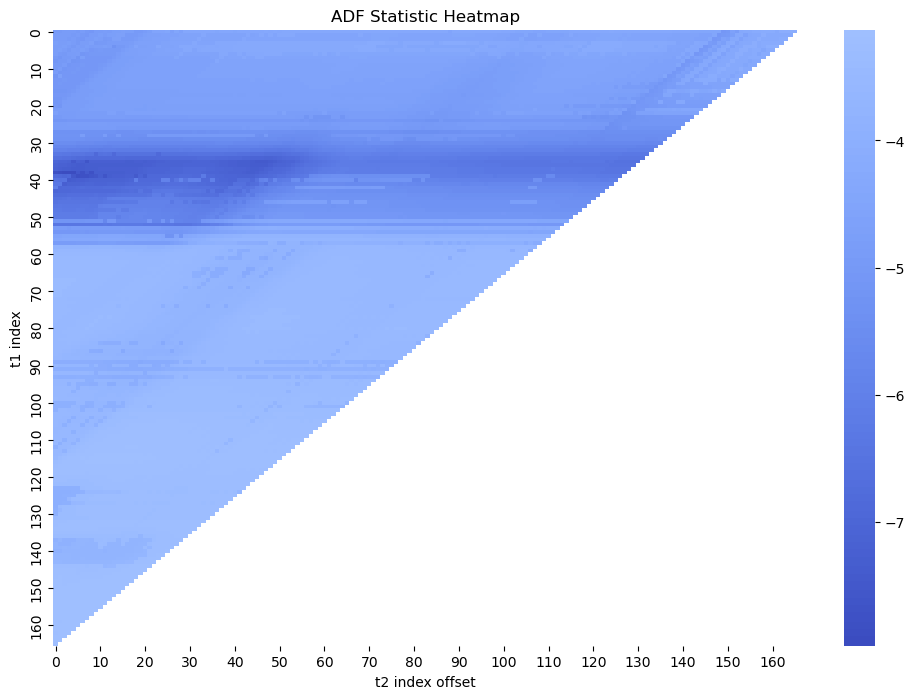

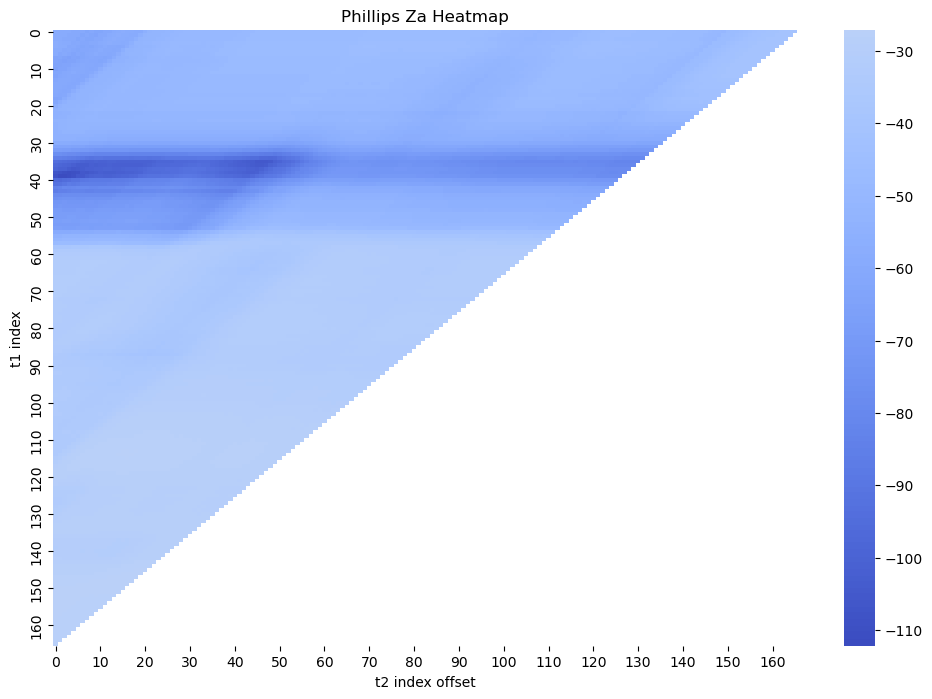

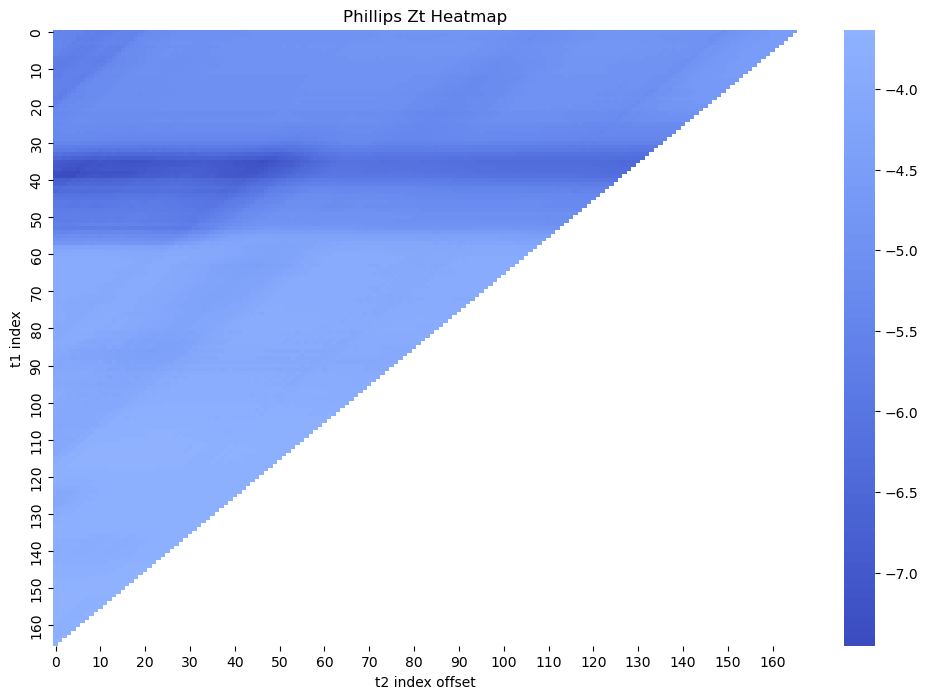

In [16]:
# heatmap 출력
plot_heatmap(adf_surface, "ADF Statistic Heatmap", t1_range)
plot_heatmap(za_surface, "Phillips Za Heatmap", t1_range)
plot_heatmap(zt_surface, "Phillips Zt Heatmap", t1_range)


In [17]:
# === 추가 출력: 회귀 계수, 표준오차, t값, 잔차 ===
# 선택된 break에 대해 회귀 재실행
D1 = np.concatenate([np.zeros(t1_star), np.ones(len(y) - t1_star)])
D2 = np.concatenate([np.zeros(t2_star), np.ones(len(y) - t2_star)])
X_star = np.column_stack([np.ones(len(y)), D1, D2, X, D1[:, None]*X, D2[:, None]*X])

b, e, sig2, se = estimate(y, X_star)
tvals = b / se
summary_df = pd.DataFrame({
    "계수": b,
    "표준오차": se,
    "t값": tvals
})
print("\n📋 회귀 계수표:")
display(summary_df)

print("\n📋 잔차 벡터 (앞 10개):")
print(e[:10])


📋 회귀 계수표:


,계수,표준오차,t값
0,1.920689,0.034469,55.722772
1,-5.887439,0.197727,-29.775548
2,6.402655,0.213065,30.050267
3,0.739986,0.006958,106.355765
4,0.094364,0.008566,11.015901
5,0.671629,0.033024,20.337645
6,-0.049827,0.024065,-2.070526
7,-0.988315,0.033777,-29.260047
8,0.287151,0.024774,11.590725



📋 잔차 벡터 (앞 10개):
[0.2420518  0.24890893 0.26860775 0.26901954 0.27190323 0.29401291
 0.29401291 0.29401291 0.29401291 0.26935864]


In [18]:
y = df["Insurance"].values
X = df[["Banks", "Securities"]].values

In [19]:
adf_surface, za_surface, zt_surface, t1_range = hatemi_j_parallel(
    y, X, model_type=4, max_lag=12, criterion='bic', step=20
)

총 테스트 조합 수: 13861 → 병렬 계산 시작


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09853315353393555s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 310 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]

In [20]:
# 최소값 위치 및 단절점 계산
min_idx = np.unravel_index(np.nanargmin(adf_surface), adf_surface.shape)
t1_star = t1_range[min_idx[0]]
t2_star = t1_star + int(0.15 * len(y)) + min_idx[1] * 10

print("📌 최소 ADF:", adf_surface[min_idx])
print("📌 1차 단절점:", df.index[t1_star])
print("📌 2차 단절점:", df.index[t2_star])

📌 최소 ADF: -6.900672950817165
📌 1차 단절점: 2007-06-04 00:00:00
📌 2차 단절점: 2014-04-11 00:00:00


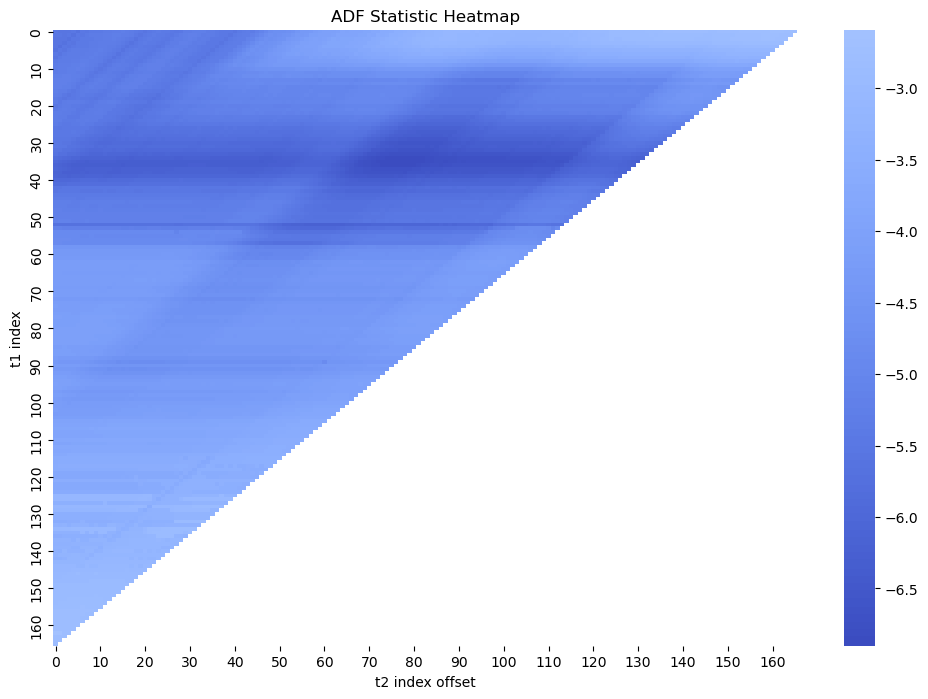

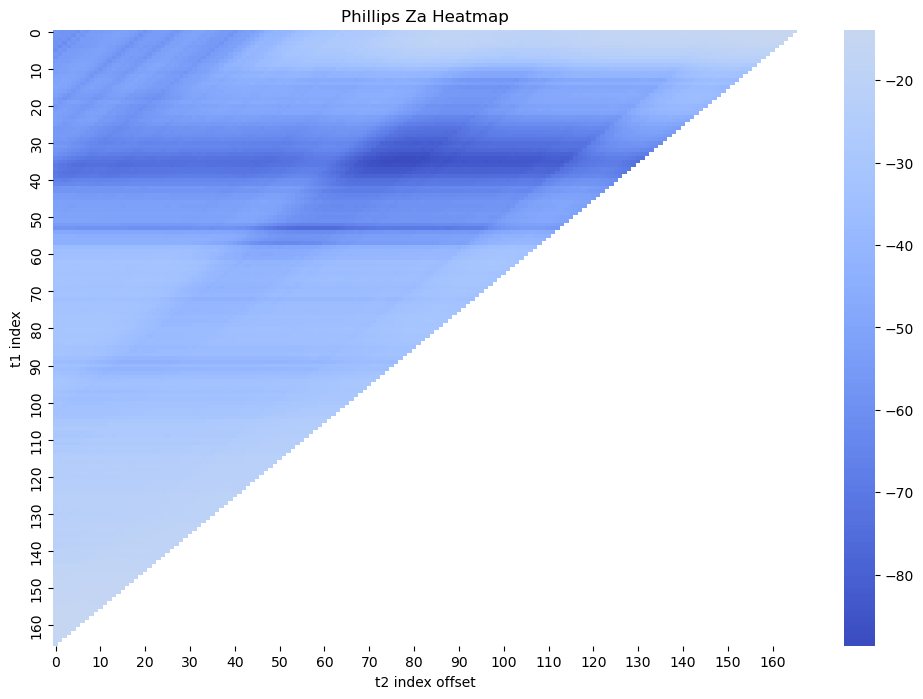

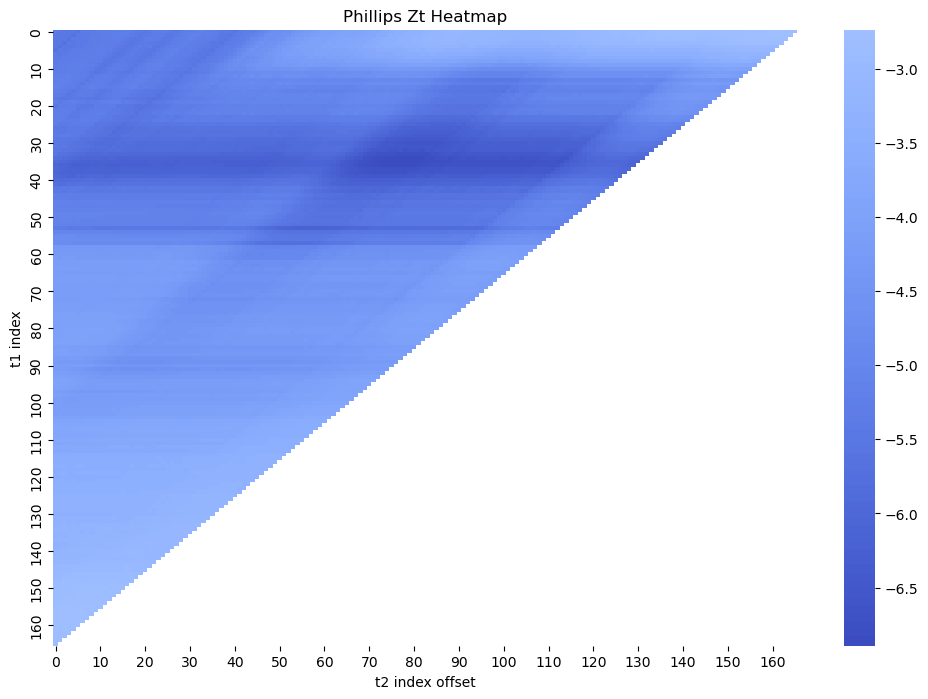

In [21]:
# heatmap 출력
plot_heatmap(adf_surface, "ADF Statistic Heatmap", t1_range)
plot_heatmap(za_surface, "Phillips Za Heatmap", t1_range)
plot_heatmap(zt_surface, "Phillips Zt Heatmap", t1_range)

In [22]:
# === 추가 출력: 회귀 계수, 표준오차, t값, 잔차 ===
# 선택된 break에 대해 회귀 재실행
D1 = np.concatenate([np.zeros(t1_star), np.ones(len(y) - t1_star)])
D2 = np.concatenate([np.zeros(t2_star), np.ones(len(y) - t2_star)])
X_star = np.column_stack([np.ones(len(y)), D1, D2, X, D1[:, None]*X, D2[:, None]*X])

b, e, sig2, se = estimate(y, X_star)
tvals = b / se
summary_df = pd.DataFrame({
    "계수": b,
    "표준오차": se,
    "t값": tvals
})
print("\n📋 회귀 계수표:")
display(summary_df)

print("\n📋 잔차 벡터 (앞 10개):")
print(e[:10])


📋 회귀 계수표:


,계수,표준오차,t값
0,-1.935642,0.054351,-35.613969
1,7.293192,0.135767,53.718299
2,-3.840864,0.172635,-22.248474
3,1.222153,0.011103,110.072058
4,-0.069495,0.011975,-5.803071
5,-0.644961,0.022004,-29.310480
6,-0.159518,0.017547,-9.090908
7,0.294125,0.026444,11.122564
8,0.213148,0.021326,9.994835



📋 잔차 벡터 (앞 10개):
[-0.37056528 -0.38016899 -0.40408417 -0.40401793 -0.40691301 -0.43583089
 -0.43583089 -0.43583089 -0.43583089 -0.40732694]


In [23]:
y = df["Securities"].values
X = df[["Banks", "Insurance"]].values

In [24]:
adf_surface, za_surface, zt_surface, t1_range = hatemi_j_parallel(
    y, X, model_type=4, max_lag=12, criterion='bic', step=20
)

총 테스트 조합 수: 13861 → 병렬 계산 시작


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06426191329956055s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 310 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]

In [25]:
# 최소값 위치 및 단절점 계산
min_idx = np.unravel_index(np.nanargmin(adf_surface), adf_surface.shape)
t1_star = t1_range[min_idx[0]]
t2_star = t1_star + int(0.15 * len(y)) + min_idx[1] * 10

print("📌 최소 ADF:", adf_surface[min_idx])
print("📌 1차 단절점:", df.index[t1_star])
print("📌 2차 단절점:", df.index[t2_star])

📌 최소 ADF: -5.606037639554599
📌 1차 단절점: 2007-06-04 00:00:00
📌 2차 단절점: 2012-11-27 00:00:00


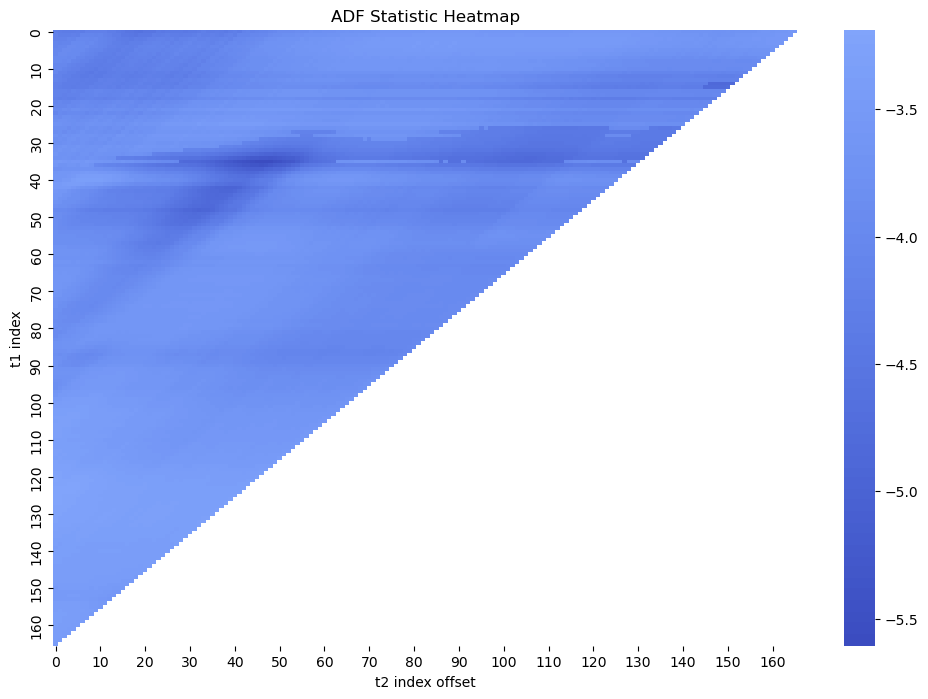

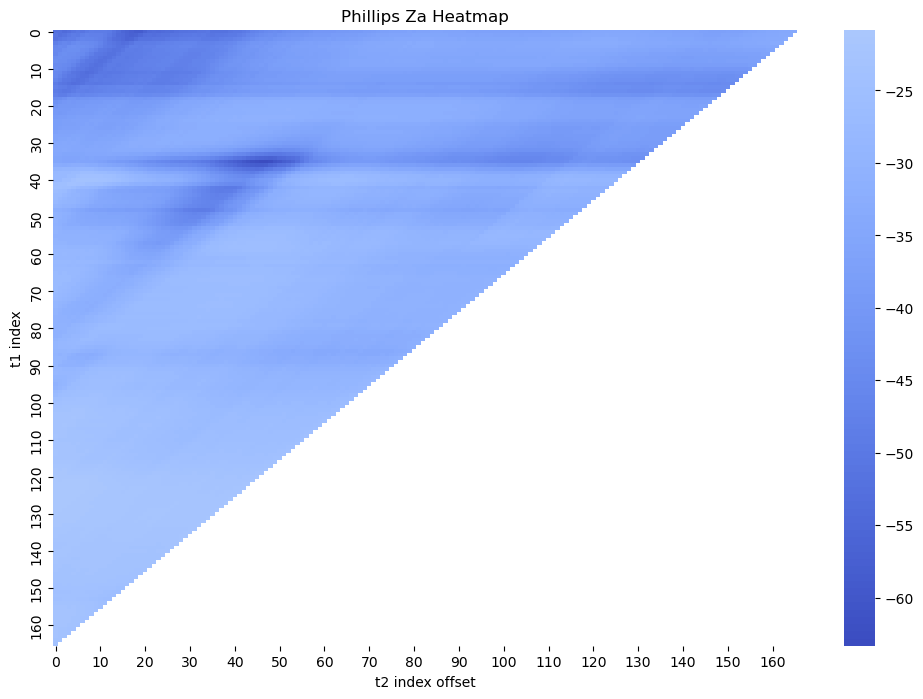

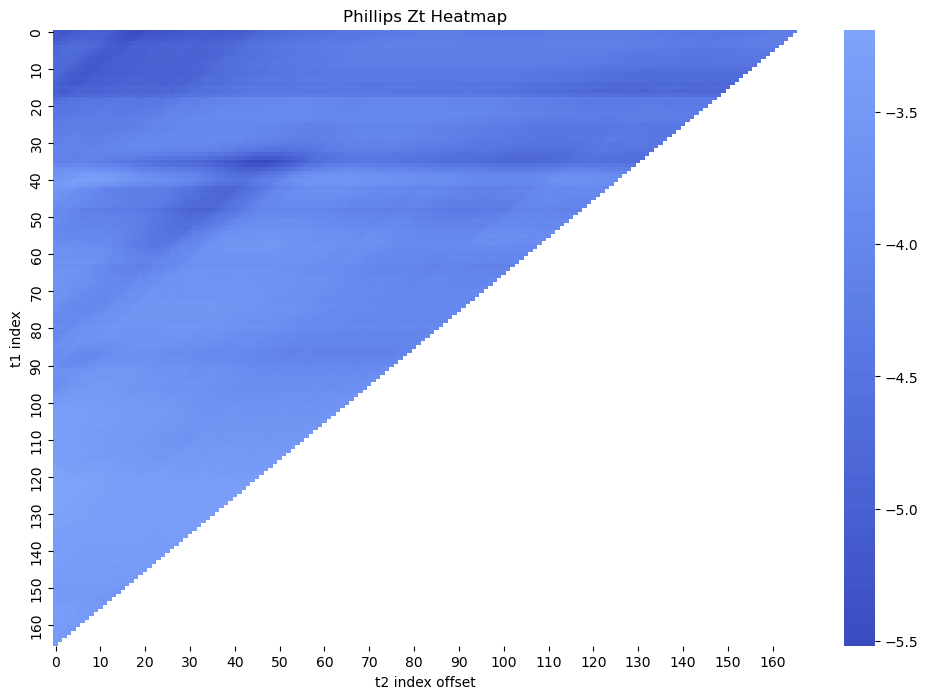

In [26]:
# heatmap 출력
plot_heatmap(adf_surface, "ADF Statistic Heatmap", t1_range)
plot_heatmap(za_surface, "Phillips Za Heatmap", t1_range)
plot_heatmap(zt_surface, "Phillips Zt Heatmap", t1_range)

In [27]:
# === 추가 출력: 회귀 계수, 표준오차, t값, 잔차 ===
# 선택된 break에 대해 회귀 재실행
D1 = np.concatenate([np.zeros(t1_star), np.ones(len(y) - t1_star)])
D2 = np.concatenate([np.zeros(t2_star), np.ones(len(y) - t2_star)])
X_star = np.column_stack([np.ones(len(y)), D1, D2, X, D1[:, None]*X, D2[:, None]*X])

b, e, sig2, se = estimate(y, X_star)
tvals = b / se
summary_df = pd.DataFrame({
    "계수": b,
    "표준오차": se,
    "t값": tvals
})
print("\n📋 회귀 계수표:")
display(summary_df)

print("\n📋 잔차 벡터 (앞 10개):")
print(e[:10])


📋 회귀 계수표:


,계수,표준오차,t값
0,-0.232068,0.119419,-1.943309
1,4.362142,0.380893,11.452419
2,-2.899459,0.406967,-7.124554
3,1.175120,0.051463,22.834308
4,-0.371064,0.043055,-8.618439
5,0.026498,0.061407,0.431515
6,-0.467549,0.072900,-6.413540
7,-0.543227,0.045005,-12.070336
8,0.851237,0.063692,13.364980



📋 잔차 벡터 (앞 10개):
[-0.17440697 -0.17749513 -0.242747   -0.25061366 -0.27692559 -0.29647108
 -0.29647108 -0.29647108 -0.29647108 -0.17290961]


In [28]:
from statsmodels.api import OLS, add_constant

def run_regime_regression(y, X, t1, t2, index):
    regimes = {
        "구간1 (초기)": (0, t1),
        "구간2 (중간)": (t1, t2),
        "구간3 (후기)": (t2, len(y))
    }

    results = {}

    for name, (start, end) in regimes.items():
        y_sub = y[start:end]
        X_sub = X[start:end]
        X_sub = add_constant(X_sub)
        model = OLS(y_sub, X_sub).fit()
        df = pd.DataFrame({
            "계수": model.params,
            "표준오차": model.bse,
            "t값": model.tvalues
        })
        results[name] = {
            "회귀표": df,
            "R2": model.rsquared,
            "표본수": end - start,
            "시작일": index[start],
            "종료일": index[end - 1]
        }

    return results

# 실행 예시 (y = Securities, X = Banks + Insurance)
regime_results = run_regime_regression(
    y=df["Securities"].values,
    X=df[["Banks", "Insurance"]].values,
    t1=t1_star,
    t2=t2_star,
    index=df.index
)

# 출력
for name, res in regime_results.items():
    print(f"\n🟦 {name} ({res['시작일'].date()} ~ {res['종료일'].date()})")
    print(f"R²: {res['R2']:.4f}, 표본 수: {res['표본수']}")
    display(res["회귀표"])



🟦 구간1 (초기) (2000-12-18 ~ 2007-06-01)
R²: 0.6476, 표본 수: 1602


,계수,표준오차,t값
0,-0.232068,0.158200,-1.466933
1,1.175120,0.068175,17.236787
2,-0.371064,0.057036,-6.505745



🟦 구간2 (중간) (2007-06-04 ~ 2012-11-26)
R²: 0.5338, 표본 수: 1372


,계수,표준오차,t값
0,4.130073,0.360920,11.443175
1,1.201618,0.033432,35.942479
2,-0.838613,0.058703,-14.285642



🟦 구간3 (후기) (2012-11-27 ~ 2025-03-31)
R²: 0.3406, 표본 수: 3043


,계수,표준오차,t값
0,1.230614,0.145087,8.481923
1,0.658392,0.023370,28.172327
2,0.012624,0.018984,0.664976
